## PEMANGGILAN LIBRARY

In [1]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import rioxarray as rxr

from glob import glob
from shapely import speedups
from rasterio import plot, mask
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches, colors

from rasterio.crs import CRS
from shapely.geometry import mapping
from matplotlib.colors import ListedColormap, BoundaryNorm

speedups.disable()
warnings.filterwarnings("ignore")

## IMPORT DATA MENTAH

In [2]:
landsat_dir = "dataset/landsat/LC08_L2SP_122065_20190522_20200828_02_T1/"
band_names = (2, 3, 4, 5, 6, "ST_TRAD", "QA_PIXEL")
coor_ref = "EPSG:4326"

year, month, date = landsat_dir[33:37], landsat_dir[37:39], landsat_dir[39:41]
time = f"{year}-{month}-{date}"

raw_band = dict()

for i in band_names:
    with rxr.open_rasterio(glob(f"{landsat_dir}*{i}.TIF*")[0], masked=True) as raster:
        if i == "ST_TRAD":
            raw_band[10] = raster.squeeze().rio.reproject(CRS.from_string(coor_ref))
        else:
            raw_band[i] = raster.squeeze().rio.reproject(CRS.from_string(coor_ref))

## KOMPOSIT BAND

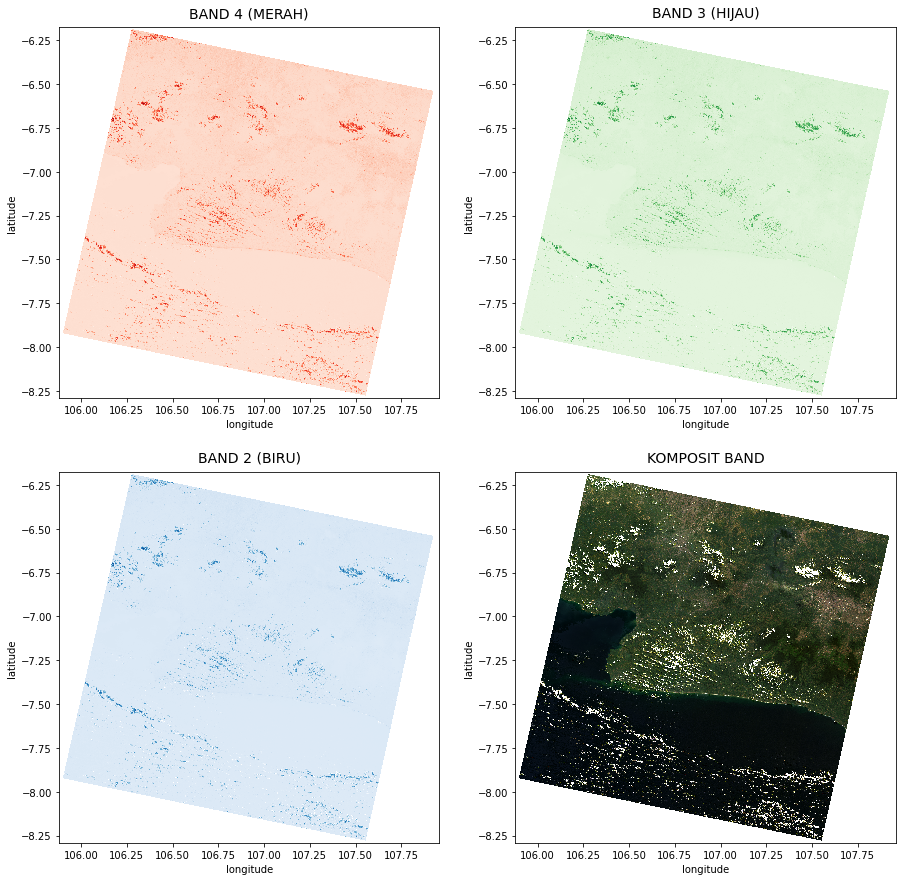

In [3]:
band_stacks = (4, 3, 2)
vmin, vmax = 0.03, 0.97
            
raw_rgb_img = xr.concat([raw_band[i] for i in band_stacks], dim="band")

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

raw_band[4].plot.imshow(ax=axs[0, 0], cmap="Reds", add_colorbar=False)
axs[0, 0].set_title("BAND 4 (MERAH)", fontsize=14, pad=10)
axs[0, 0].set_xlabel("longitude")
axs[0, 0].set_ylabel("latitude")

raw_band[3].plot.imshow(ax=axs[0, 1], cmap="Greens", add_colorbar=False)
axs[0, 1].set_title("BAND 3 (HIJAU)", fontsize=14, pad=10)
axs[0, 1].set_xlabel("longitude")
axs[0, 1].set_ylabel("latitude")

raw_band[2].plot.imshow(ax=axs[1, 0], cmap="Blues", add_colorbar=False)
axs[1, 0].set_title("BAND 2 (BIRU)", fontsize=14, pad=10)
axs[1, 0].set_xlabel("longitude")
axs[1, 0].set_ylabel("latitude")

raw_rgb_img.plot.imshow(ax=axs[1, 1], 
                        vmin=raw_rgb_img.quantile(vmin),
                        vmax=raw_rgb_img.quantile(vmax))
axs[1, 1].set_title("KOMPOSIT BAND", fontsize=14, pad=10)
axs[1, 1].set_xlabel("longitude")
axs[1, 1].set_ylabel("latitude")

plt.show()

## KALIBRASI RADIOMETRIK

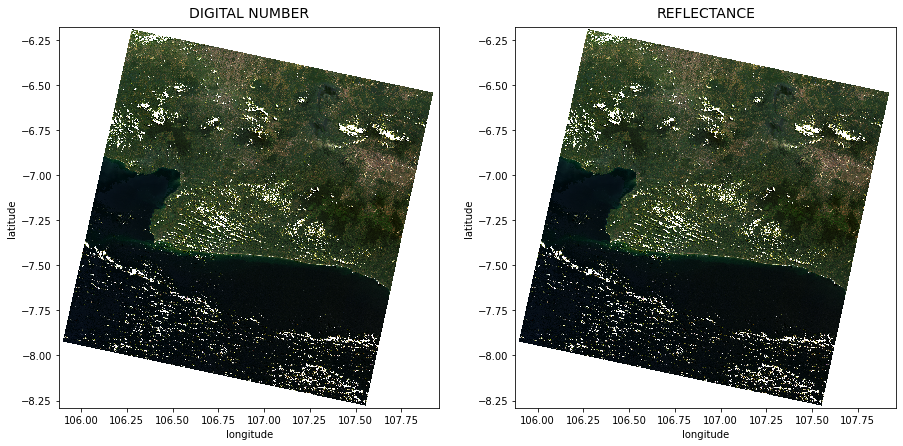

In [4]:
metadata = dict()

with open(glob(f"{landsat_dir}*MTL.TXT*")[0]) as file:
    for line in file:
        name, value = line.partition("=")[::2]
        if re.findall(f"CONSTANT_BAND_10", name):
            metadata[name.strip()[:2]] = float(value.strip()) 

calibrated_band = dict()

for i in raw_band.keys():
    if type(i) == int:
        if i < 10:
            calibrated_band[i] = raw_band[i] * 0.0000275 + -0.2
        else:
            radiance = raw_band[i] * 0.001 
            calibrated_band[i] = metadata["K2"] / np.log(metadata["K1"] / radiance + 1) - 273.15
    else:
        calibrated_band[i] = raw_band[i]
    
calibrated_rgb_img = xr.concat([calibrated_band[i] for i in band_stacks], dim="band")

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

raw_rgb_img.plot.imshow(ax=axs[0],
                        vmin=raw_rgb_img.quantile(vmin),
                        vmax=raw_rgb_img.quantile(vmax))
axs[0].set_title("DIGITAL NUMBER", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

calibrated_rgb_img.plot.imshow(ax=axs[1],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
axs[1].set_title("REFLECTANCE", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

plt.show()

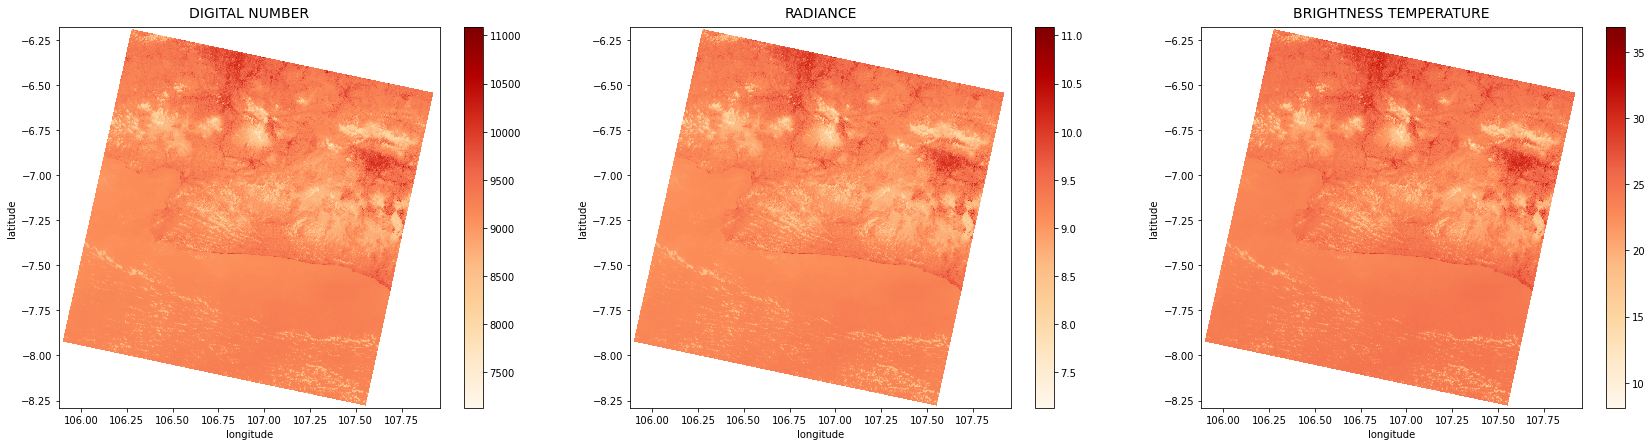

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(29, 7))

raw_band[10].plot.imshow(ax=axs[0], cmap="OrRd")
axs[0].set_title("DIGITAL NUMBER", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

radiance.plot.imshow(ax=axs[1], cmap="OrRd")
axs[1].set_title("RADIANCE", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

calibrated_band[10].plot.imshow(ax=axs[2], cmap="OrRd")
axs[2].set_title("BRIGHTNESS TEMPERATURE", fontsize=14, pad=10)
axs[2].set_xlabel("longitude")
axs[2].set_ylabel("latitude")

plt.show()

## PEMOTONGAN CITRA

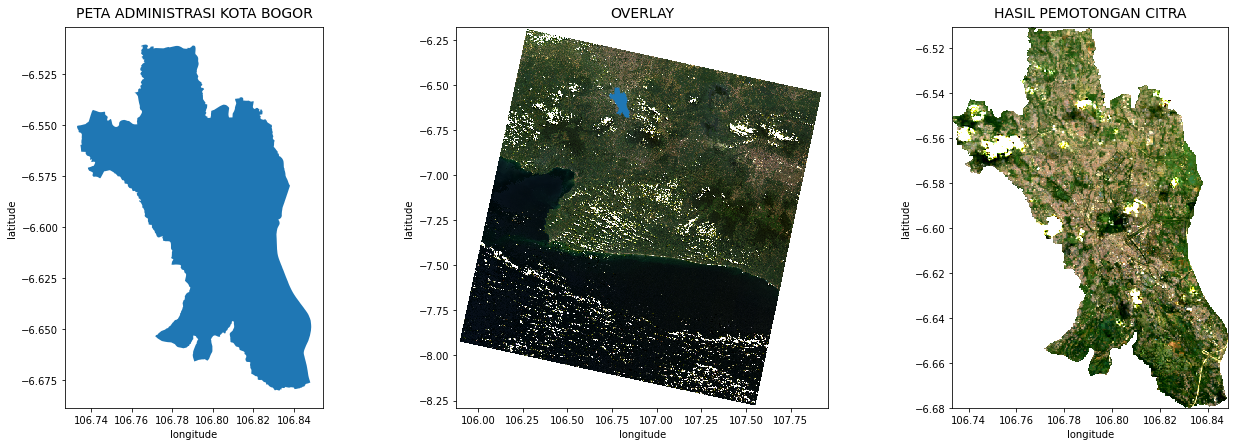

kota bogor menempati 0.32% citra landsat


In [6]:
shape = gpd.read_file("dataset/shape/kotabogor/kotabogor.shp").to_crs(coor_ref)

clipped_band = dict()

for i in calibrated_band.keys():
    clipped_band[i] = calibrated_band[i].rio.clip(shape.geometry.apply(mapping), shape.crs)

clipped_rgb_img = xr.concat([clipped_band[i] for i in band_stacks], dim="band")

fig, axs = plt.subplots(1, 3, figsize=(21, 7), gridspec_kw={'width_ratios': [1.2, 2.1, 1.2]})

shape.plot(ax = axs[0])
axs[0].set_title("PETA ADMINISTRASI KOTA BOGOR", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

calibrated_rgb_img.plot.imshow(ax=axs[1],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
shape.plot(ax=axs[1])
axs[1].set_title("OVERLAY", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

clipped_rgb_img.plot.imshow(ax=axs[2],
                            vmin=clipped_rgb_img.quantile(vmin+0.005),
                            vmax=clipped_rgb_img.quantile(vmax-0.005))
axs[2].set_title("HASIL PEMOTONGAN CITRA", fontsize=14, pad=10)
axs[2].set_xlabel("longitude")
axs[2].set_ylabel("latitude")

plt.show()

area_landsat = calibrated_band[[*calibrated_band.keys()][0]].count().values
area_landsat_kotabogor = clipped_band[[*clipped_band.keys()][0]].count().values
area_landsat_clipped_pc = round(area_landsat_kotabogor / area_landsat * 100, 2)

print(f"kota bogor menempati {area_landsat_clipped_pc}% citra landsat")

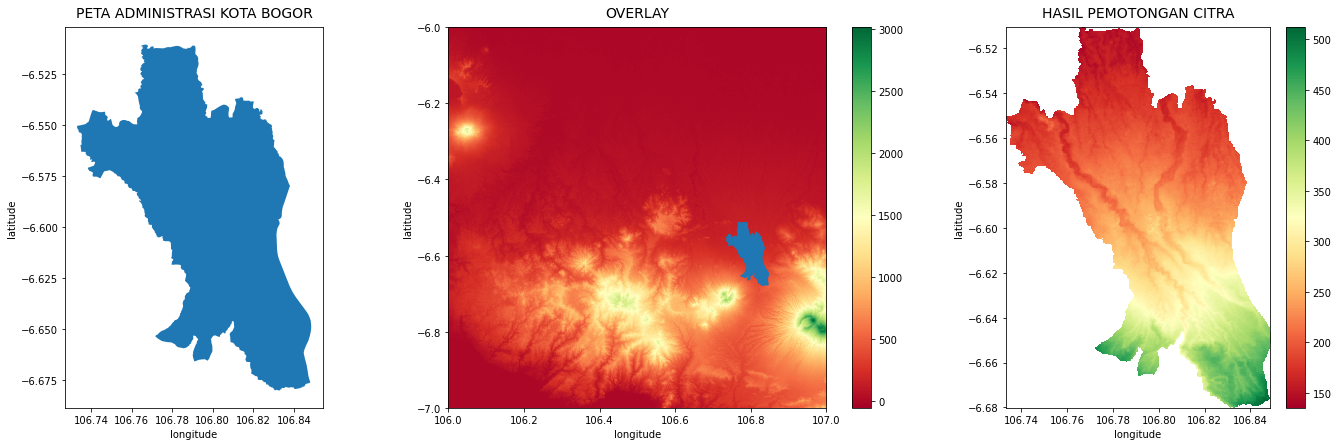

kota bogor menempati 0.96% citra srtm


In [7]:
srtm = rxr.open_rasterio("dataset/srtm/srtm.tif", masked=True).squeeze().rio.reproject(CRS.from_string(coor_ref))
elevation = srtm.rio.clip(shape.geometry.apply(mapping), shape.crs)

fig, axs = plt.subplots(1, 3, figsize=(23, 7), 
                        gridspec_kw={'width_ratios': [1.2, 2.2, 1.4]})

shape.plot(ax = axs[0])
axs[0].set_title("PETA ADMINISTRASI KOTA BOGOR", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

srtm.plot.imshow(ax=axs[1],
                 cmap="RdYlGn",
                 vmin=srtm.min(),
                 vmax=srtm.max(),
                 cbar_kwargs={"label": ""})
shape.plot(ax=axs[1])
axs[1].set_title("OVERLAY", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

elevation.plot.imshow(ax=axs[2],
                      cmap="RdYlGn", 
                      vmin=elevation.min(),
                      vmax=elevation.max(), 
                      cbar_kwargs={"label": ""})
axs[2].set_title("HASIL PEMOTONGAN CITRA", fontsize=14, pad=10)
axs[2].set_xlabel("longitude")
axs[2].set_ylabel("latitude")

plt.show()

area_srtm = srtm.count().values
area_srtm_kotabogor = elevation.count().values
area_srtm_clipped_pc = round(area_srtm_kotabogor / area_srtm * 100, 2)

print(f"kota bogor menempati {area_srtm_clipped_pc}% citra srtm")

## PENGHAPUSAN AWAN DAN BAYANGAN AWAN

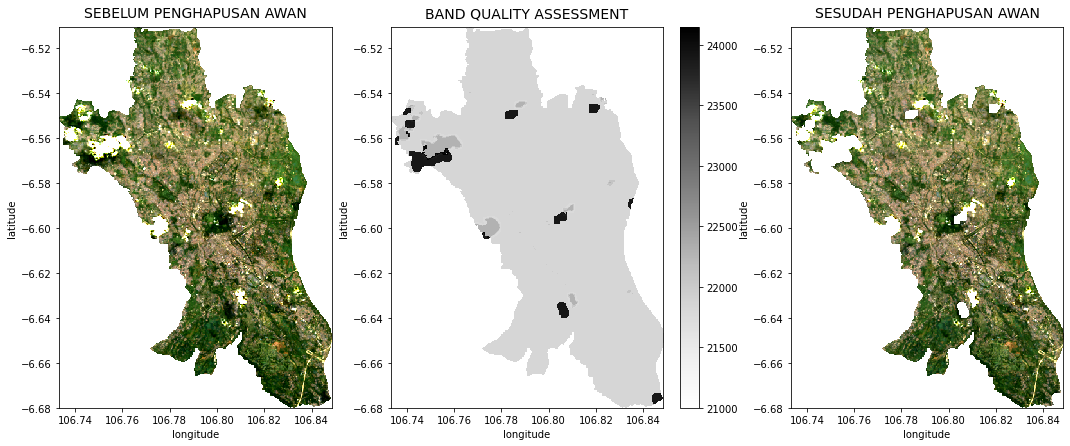

luas kota bogor 116.8101 km²
luas kota bogor tanpa awan 110.9421 km² atau 94.98%


In [8]:
qa_pixel = clipped_band["QA_PIXEL"].where(~clipped_band["QA_PIXEL"].isin([-9999, 3.4028234663852886e+38]))
qa_pixel_arr = qa_pixel.values.tolist()
removed_pixel = list()

for i in qa_pixel_arr:
    for j in i:
        if ~np.isnan(j):
            bin_pixel = np.binary_repr(int(j))
            if bin_pixel[-4] == "1" or bin_pixel[-5] == "1" or bin_pixel[-10] == "1":
                dec_pixel = int(bin_pixel, 2)
                if dec_pixel not in removed_pixel:
                    removed_pixel.append(dec_pixel)

cleared_band = dict()

for i in [*clipped_band.keys()][:-1]:
    cleared_band[i] = clipped_band[i].where(~clipped_band["QA_PIXEL"].isin(removed_pixel))
    
cleared_rgb_img = xr.concat([cleared_band[i] for i in band_stacks], dim="band")

fig, axs = plt.subplots(1, 3, figsize=(18, 7),  gridspec_kw={'width_ratios': [1, 1.25, 1]})

clipped_rgb_img.plot.imshow(ax=axs[0],
                            vmin=clipped_rgb_img.quantile(vmin+0.005),
                            vmax=clipped_rgb_img.quantile(vmax-0.005))
axs[0].set_title("SEBELUM PENGHAPUSAN AWAN", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

qa_pixel.plot.imshow(ax=axs[1],
                     cmap="Greys",
                     vmin=21000,
                     vmax=qa_pixel.max())
axs[1].set_title("BAND QUALITY ASSESSMENT", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

cleared_rgb_img.plot.imshow(ax=axs[2], 
                            vmin=cleared_rgb_img.quantile(vmin-0.018),
                            vmax=cleared_rgb_img.quantile(vmax+0.018))
axs[2].set_title("SESUDAH PENGHAPUSAN AWAN", fontsize=14, pad=10)
axs[2].set_xlabel("longitude")
axs[2].set_ylabel("latitude")

plt.show()

area_landsat_kotabogor = clipped_band[[*clipped_band.keys()][0]].count().values
area_kotabogor_km = area_landsat_kotabogor * 900 / 1000000
cleared_area = cleared_band[[*cleared_band.keys()][0]].count().values
cleared_area_km = cleared_area * 900 / 1000000
cleared_area_pc = round(cleared_area_km / area_kotabogor_km * 100, 2)

print(f"luas kota bogor {area_kotabogor_km} km\N{SUPERSCRIPT TWO}")
print(f"luas kota bogor tanpa awan {cleared_area_km} km\N{SUPERSCRIPT TWO} atau {cleared_area_pc}%")

## PENYIMPANAN DATA

In [9]:
if not os.path.exists(f"output/landsat/{time}"):
    os.makedirs(f"output/landsat/{time}")

for i in cleared_band.keys():
    cleared_band[i].rio.to_raster(f"output/landsat/{time}/B{i}.TIF")

In [10]:
daily_climate = pd.read_csv(f"dataset/climate/daily_{year}.csv")
daily_climate = daily_climate.loc[daily_climate["time"] == time]
daily_climate = daily_climate.assign(julian=daily_climate.index[0]+1,
                                     clear_area_km=cleared_area_km,
                                     clear_area_pc=cleared_area_pc)

if not os.path.isfile("output/climate/landsat-climate.csv"):
    pd.DataFrame(columns=["time"]).to_csv("output/climate/landsat-climate.csv", index=False)
    
landsat_climate = pd.read_csv("output/climate/landsat-climate.csv")
    
if time in landsat_climate["time"].values:
    index = landsat_climate.loc[landsat_climate["time"] == time].index
    landsat_climate = landsat_climate.drop(index)
    
landsat_climate = landsat_climate.append(daily_climate).sort_values(by="time")
landsat_climate = landsat_climate.drop(columns=["evaporation", "solar_radiation"])
landsat_climate = landsat_climate.set_index(pd.Index([*range(len(landsat_climate))]))
landsat_climate.to_csv("output/climate/landsat-climate.csv", index=False)
landsat_climate = pd.read_csv(f"output/climate/landsat-climate.csv")
landsat_climate.loc[landsat_climate["clear_area_pc"] == 100]

,time,temperature_avg,temperature_min,temperature_max,relative_humidity,sunshine_duration,wind_velocity,precipitation,julian,clear_area_km,clear_area_pc
1,2019-07-25,25.850,21.2,33.2,70.158,6.7,0.565,0.0,206.0,116.8209,100.0
2,2019-09-11,26.325,19.7,34.5,61.193,8.0,0.806,0.0,254.0,116.8146,100.0
3,2020-05-24,26.750,22.5,34.1,80.077,6.8,0.695,0.0,145.0,116.8101,100.0
